In [1]:
import pandas as pd
import geopandas as gpd
import libpysal as ps
import networkx as nx
import folium
from folium.plugins import MarkerCluster

In [8]:
lfe = pd.read_csv(r'data\tract_life_expectancy.csv')[['Tract ID', 'e(0)']].rename(index=str, columns={'Tract ID': 'GEOID', 'e(0)':'life_expectancy'})
lfe['GEOID'] = lfe['GEOID'].astype(str)

gdf = gpd.read_file(r'data\us_tract_boundaries\usa_tracts.shp')[['GEOID','geometry']]
gdf = gdf.merge(lfe)

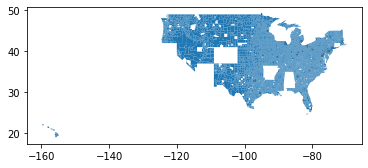

In [9]:
gdf.plot();

In [4]:
gdf.head(1)

,geometry,life_expectancy
GEOID,,
10001041600,"POLYGON ((-75.53657 39.11521, -75.53647 39.115...",75.0


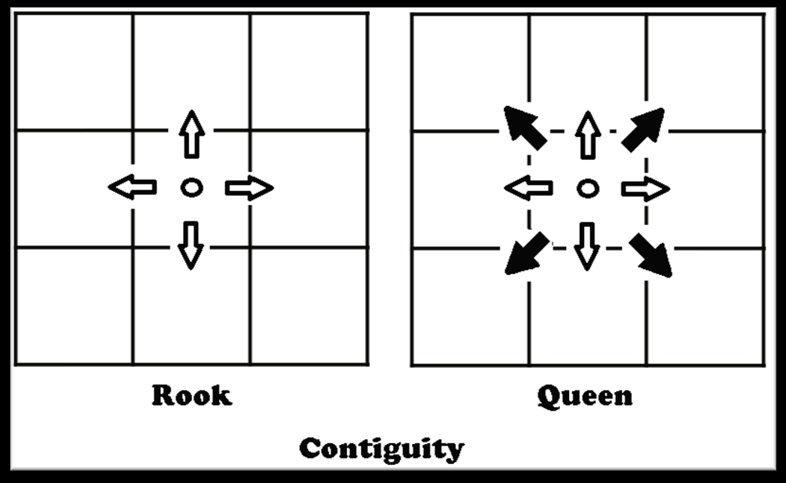

In [9]:
swm = ps.weights.Rook.from_dataframe(gdf, ids='GEOID')
tract_to_neighbors = swm.neighbors

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 67 disconnected components.
 There are 36 islands with ids: 12057014009, 12086003707, 12103020106, 13121003600, 15009031601, 20209042600, 21163970100, 25001010100, 26065002901, 26163518500, 30007000100, 35053978302, 36005051600, 36053030501, 36081091601, 36081092200, 36081107201, 37031970200, 39025041800, 39049007047, 42011014000, 42021013000, 42049010201, 44005041300, 44009041500, 48035950500, 48113007818, 48121021732, 48201433600, 48355005102, 48485013700, 51710001100, 53053072410, 53073010900, 53073011000, 56017967800.
  warnings.warn(message)


In [11]:
fips_to_lfe = dict(zip(lfe['GEOID'].astype(str), lfe['life_expectancy']))

In [14]:
g = nx.Graph()
g.add_nodes_from(gdf['GEOID'])

In [16]:
avail_tracts = set(fips_to_lfe.keys())
for tract, neighbors in tract_to_neighbors.items():
    avail_tracts = fips_to_lfe.keys()
    # some tracts don't seem to show up in the life expectancy dataset
    # these may be tracts with no population
    if tract in avail_tracts:
        for neighbor in neighbors:
            if neighbor in avail_tracts:
                tract_lfe = fips_to_lfe[tract]
                neighbor_lfe = fips_to_lfe[neighbor]
                disparity = abs(tract_lfe - neighbor_lfe)
                g.add_edge(tract, neighbor, disparity=disparity)
    # remove the node from the graph if the node is not in the life
    # expectancy dataset
    elif tract in g.nodes:
        g.remove_node(tract)

In [20]:
sorted_list = sorted(g.edges(data=True), key=lambda x: x[2]['disparity'], reverse=True)
print(sorted_list[:100])

[('36061015200', '36061023802', {'disparity': 28.799999999999997}), ('36061023802', '36061013200', {'disparity': 28.700000000000003}), ('36061013600', '36061023802', {'disparity': 26.200000000000003}), ('54045956200', '54045956900', {'disparity': 24.000000000000007}), ('54045956800', '54045956900', {'disparity': 23.500000000000007}), ('51710004900', '51710004200', {'disparity': 23.400000000000006}), ('34033022000', '34033021202', {'disparity': 23.099999999999994}), ('54017965000', '54033031600', {'disparity': 22.999999999999993}), ('54045956400', '54045956900', {'disparity': 22.300000000000004}), ('36061023802', '36061023801', {'disparity': 22.200000000000003}), ('40091780200', '40121485800', {'disparity': 21.400000000000006}), ('51710004900', '51710004100', {'disparity': 21.000000000000007}), ('51710004001', '51710004100', {'disparity': 20.800000000000004}), ('54089000600', '54089000700', {'disparity': 20.699999999999996}), ('40015162100', '40015162000', {'disparity': 20.6000000000000

In [22]:
top_50 = sorted_list[:50]

top_50_tracts = []
for t in top_50:
    if t[0] not in top_50_tracts:
        top_50_tracts.append(t[0])
    if t[1] not in top_50_tracts:
        top_50_tracts.append(t[1])

top_50_tracts_gdf = gdf[gdf.GEOID.isin(top_50_tracts)] \
    .reset_index() \
    [['GEOID', 'geometry', 'life_expectancy']]
top_50_tracts_gdf.to_file(r'results\selected_tracts.geojson', driver='GeoJSON')

In [23]:
m = folium.Map(tiles='cartodbpositron', min_zoom=4, zoom_start=4.25, 
               max_bounds=True,location=[33.8283459,-98.5794797],
               min_lat=5.499550, min_lon=-160.276413, 
               max_lat=83.162102, max_lon=-52.233040)

marker_cluster = MarkerCluster(
    options = {'maxClusterRadius':15, 
               'disableCusteringAtZoom':5, 
               'singleMarkerMode':True}).add_to(m)

folium.Choropleth(
    geo_data = 'selected_tracts.geojson',
    data = lfe,
    columns = ['GEOID','life_expectancy'],
    fill_color = 'YlGn',
    key_on = 'feature.properties.GEOID',
    name = 'geojson',
    legend_name='Life Expectancy'
).add_to(m)

for i, tract in top_50_tracts_gdf.iterrows():
    x = tract.geometry.centroid.x
    y = tract.geometry.centroid.y
    l = tract.life_expectancy
    folium.CircleMarker([y, x], radius=8, color='black', 
                        fill_color='white', fill_opacity=0.5, 
                        tooltip='Life expectancy: {}'.format(str(l))).add_to(marker_cluster)
    
f = folium.Figure()
title = '<h2>Does your census tract determine how ' + \
        'long you will live?</h2>'
subtitle = '<h4><i>Census tract neighbors across ' + \
           'the U.S. with the widest disparities ' + \
           'in life expectancy<i></h4>'
f.html.add_child(folium.Element(title))
f.html.add_child(folium.Element(subtitle))
f.add_child(m)

f